## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.8, 0.5, 0.2]
redice_lr_patient = [5, 10, 15]

In [8]:
import itertools
from keras.callbacks import ReduceLROnPlateau

results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """

    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=reduce_patient, 
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.80, reduce_patient: 5
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
b

50000/50000 [==============================] - 12s 241us/step - loss: 1.3351 - accuracy: 0.5341 - val_loss: 1.4814 - val_accuracy: 0.4771
Epoch 11/25
50000/50000 [==============================] - 12s 231us/step - loss: 1.3092 - accuracy: 0.5433 - val_loss: 1.4793 - val_accuracy: 0.4761
Epoch 12/25
50000/50000 [==============================] - 9s 186us/step - loss: 1.2869 - accuracy: 0.5509 - val_loss: 1.4733 - val_accuracy: 0.4741
Epoch 13/25
50000/50000 [==============================] - 6s 123us/step - loss: 1.2627 - accuracy: 0.5603 - val_loss: 1.4658 - val_accuracy: 0.4835
Epoch 14/25
50000/50000 [==============================] - 7s 131us/step - loss: 1.2400 - accuracy: 0.5688 - val_loss: 1.4642 - val_accuracy: 0.4854
Epoch 15/25
50000/50000 [==============================] - 8s 160us/step - loss: 1.2199 - accuracy: 0.5765 - val_loss: 1.4555 - val_accuracy: 0.4834
Epoch 16/25
50000/50000 [==============================] - 8s 166us/step - loss: 1.1992 - accuracy: 0.5847 - val_los

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 12s 242us/step - loss: 2.2639 - accuracy: 0.2648 - val_loss: 2.1812 - val_accuracy: 0.1605
Epoch 2/25
50000/50000 [==============================] - 8s 161us/step - loss: 1.7630 - accuracy: 0.3852 - val_loss: 2.0020 - val_accuracy: 0.2833
Epoch 3/25
50000/50000 [==============================] - 7s 146us/step - loss: 1.6309 - accuracy: 0.4277 - val_loss: 1.8460 - val_accuracy: 0.3583
Epoch 4/25
50000/50000 [==============================] - 6s 115us/step - loss: 1.5542 - accuracy: 0.4528 - val_loss: 1.7254 - val_accuracy: 0.4010
Epoch 5/25
50000/50000 [==============================] - 6s 114us/step - loss: 1.5020 - accuracy: 0.4713 - val_loss: 1.6383 - val_accuracy: 0.4271
Epoch 6/25
50000/50000 [==============================] - 5s 99us/step - loss: 1.4583 - accuracy: 0.4870 - val_loss: 1.5919 - val_accuracy: 0.4403
Epoch 7/25
50000/50000 [==============================] - 5s 9

50000/50000 [==============================] - 8s 161us/step - loss: 1.1224 - accuracy: 0.6164 - val_loss: 1.4397 - val_accuracy: 0.4945
Epoch 21/25
50000/50000 [==============================] - 8s 161us/step - loss: 1.1054 - accuracy: 0.6200 - val_loss: 1.4402 - val_accuracy: 0.4901
Epoch 22/25
50000/50000 [==============================] - 8s 165us/step - loss: 1.0871 - accuracy: 0.6277 - val_loss: 1.4361 - val_accuracy: 0.4987
Epoch 23/25
50000/50000 [==============================] - 8s 161us/step - loss: 1.0701 - accuracy: 0.6348 - val_loss: 1.4418 - val_accuracy: 0.4978
Epoch 24/25
50000/50000 [==============================] - 8s 159us/step - loss: 1.0528 - accuracy: 0.6408 - val_loss: 1.4337 - val_accuracy: 0.4976
Epoch 25/25
50000/50000 [==============================] - 8s 152us/step - loss: 1.0354 - accuracy: 0.6470 - val_loss: 1.4460 - val_accuracy: 0.4940
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 15
Model: "model_6"
__________________________________________

Epoch 5/25
50000/50000 [==============================] - 8s 167us/step - loss: 1.5008 - accuracy: 0.4745 - val_loss: 1.6412 - val_accuracy: 0.4308
Epoch 6/25
50000/50000 [==============================] - 8s 154us/step - loss: 1.4582 - accuracy: 0.4896 - val_loss: 1.5871 - val_accuracy: 0.4415
Epoch 7/25
50000/50000 [==============================] - 8s 163us/step - loss: 1.4217 - accuracy: 0.5048 - val_loss: 1.5447 - val_accuracy: 0.4503
Epoch 8/25
50000/50000 [==============================] - 8s 163us/step - loss: 1.3895 - accuracy: 0.5151 - val_loss: 1.5447 - val_accuracy: 0.4521
Epoch 9/25
50000/50000 [==============================] - 8s 161us/step - loss: 1.3606 - accuracy: 0.5264 - val_loss: 1.5077 - val_accuracy: 0.4627
Epoch 10/25
50000/50000 [==============================] - 8s 164us/step - loss: 1.3332 - accuracy: 0.5333 - val_loss: 1.4991 - val_accuracy: 0.4645
Epoch 11/25
50000/50000 [==============================] - 8s 166us/step - loss: 1.3080 - accuracy: 0.5451 - va

50000/50000 [==============================] - 10s 192us/step - loss: 1.0643 - accuracy: 0.6368 - val_loss: 1.4515 - val_accuracy: 0.4912
Epoch 25/25
50000/50000 [==============================] - 9s 172us/step - loss: 1.0484 - accuracy: 0.6419 - val_loss: 1.4420 - val_accuracy: 0.4960
Numbers of exp: 8, reduce_factor: 0.20, reduce_patient: 15
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_25 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
___________________________________________

Epoch 9/25
50000/50000 [==============================] - 9s 177us/step - loss: 1.0193 - accuracy: 0.6397 - val_loss: 1.7845 - val_accuracy: 0.4016
Epoch 10/25
50000/50000 [==============================] - 9s 174us/step - loss: 0.9703 - accuracy: 0.6594 - val_loss: 1.7452 - val_accuracy: 0.4159
Epoch 11/25
50000/50000 [==============================] - 8s 161us/step - loss: 0.9213 - accuracy: 0.6778 - val_loss: 1.8756 - val_accuracy: 0.4233
Epoch 12/25
50000/50000 [==============================] - 9s 171us/step - loss: 0.8833 - accuracy: 0.6928 - val_loss: 1.8549 - val_accuracy: 0.4148

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
Epoch 13/25
50000/50000 [==============================] - 9s 170us/step - loss: 0.8097 - accuracy: 0.7213 - val_loss: 1.6848 - val_accuracy: 0.4454
Epoch 14/25
50000/50000 [==============================] - 8s 169us/step - loss: 0.7699 - accuracy: 0.7350 - val_loss: 1.6741 - val_accuracy: 0.4609
Epoch 15/25
50000/50000 [==

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 14s 286us/step - loss: 1.7893 - accuracy: 0.3771 - val_loss: 2.6399 - val_accuracy: 0.2306
Epoch 2/25
50000/50000 [==============================] - 9s 179us/step - loss: 1.5078 - accuracy: 0.4660 - val_loss: 1.9132 - val_accuracy: 0.3294
Epoch 3/25
50000/50000 [==============================] - 9s 180us/step - loss: 1.4026 - accuracy: 0.5030 - val_loss: 1.7091 - val_accuracy: 0.3808
Epoch 4/25
50000/50000 [==============================] - 9s 177us/step - loss: 1.3254 - accuracy: 0.5310 - val_loss: 1.6027 - val_accuracy: 0.4277
Epoch 5/25
50000/50000 [==============================] - 9s 172us/step - loss: 1.2640 - accuracy: 0.5528 - val_loss: 1.5112 - val_accuracy: 0.4611
Epoch 6/25
50000/50000 [==============================] - 8s 167us/step - loss: 1.2151 - accuracy: 0.5729 - val_loss: 1.4975 - val_accuracy: 0.4697
Epoch 7/25
50000/50000 [==============================] - 9s 

Epoch 20/25
50000/50000 [==============================] - 8s 160us/step - loss: 0.6854 - accuracy: 0.7727 - val_loss: 1.4701 - val_accuracy: 0.5143
Epoch 21/25
50000/50000 [==============================] - 8s 160us/step - loss: 0.6649 - accuracy: 0.7806 - val_loss: 1.4705 - val_accuracy: 0.5165
Epoch 22/25
50000/50000 [==============================] - 8s 167us/step - loss: 0.6459 - accuracy: 0.7878 - val_loss: 1.5171 - val_accuracy: 0.5141
Epoch 23/25
50000/50000 [==============================] - 9s 172us/step - loss: 0.6244 - accuracy: 0.7953 - val_loss: 1.4909 - val_accuracy: 0.5206

Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.00010240000847261399.
Epoch 24/25
50000/50000 [==============================] - 9s 180us/step - loss: 0.5833 - accuracy: 0.8138 - val_loss: 1.4713 - val_accuracy: 0.5264
Epoch 25/25
50000/50000 [==============================] - 9s 185us/step - loss: 0.5640 - accuracy: 0.8231 - val_loss: 1.4718 - val_accuracy: 0.5309
Numbers of exp: 13, redu

50000/50000 [==============================] - 7s 147us/step - loss: 1.4743 - accuracy: 0.4845 - val_loss: 1.7593 - val_accuracy: 0.3888
Epoch 4/25
50000/50000 [==============================] - 8s 161us/step - loss: 1.4057 - accuracy: 0.5101 - val_loss: 1.6515 - val_accuracy: 0.4310
Epoch 5/25
50000/50000 [==============================] - 9s 174us/step - loss: 1.3571 - accuracy: 0.5262 - val_loss: 1.6235 - val_accuracy: 0.4198
Epoch 6/25
50000/50000 [==============================] - 8s 162us/step - loss: 1.3163 - accuracy: 0.5416 - val_loss: 1.5399 - val_accuracy: 0.4547
Epoch 7/25
50000/50000 [==============================] - 9s 173us/step - loss: 1.2785 - accuracy: 0.5545 - val_loss: 1.5247 - val_accuracy: 0.4684
Epoch 8/25
50000/50000 [==============================] - 9s 171us/step - loss: 1.2480 - accuracy: 0.5662 - val_loss: 1.4663 - val_accuracy: 0.4841
Epoch 9/25
50000/50000 [==============================] - 9s 172us/step - loss: 1.2197 - accuracy: 0.5779 - val_loss: 1.479

Epoch 23/25
50000/50000 [==============================] - 8s 166us/step - loss: 0.9371 - accuracy: 0.6869 - val_loss: 1.4325 - val_accuracy: 0.4974
Epoch 24/25
50000/50000 [==============================] - 9s 174us/step - loss: 0.9230 - accuracy: 0.6922 - val_loss: 1.4792 - val_accuracy: 0.4947
Epoch 25/25
50000/50000 [==============================] - 9s 173us/step - loss: 0.9091 - accuracy: 0.6974 - val_loss: 1.4191 - val_accuracy: 0.5061

Epoch 00025: ReduceLROnPlateau reducing learning rate to 1.0240000847261399e-05.
Numbers of exp: 16, reduce_factor: 0.20, reduce_patient: 10
Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_______________________________________________________________

50000/50000 [==============================] - 9s 189us/step - loss: 1.5659 - accuracy: 0.4526 - val_loss: 1.6563 - val_accuracy: 0.4138
Epoch 8/25
50000/50000 [==============================] - 9s 174us/step - loss: 1.5424 - accuracy: 0.4615 - val_loss: 1.6309 - val_accuracy: 0.4239
Epoch 9/25
50000/50000 [==============================] - 9s 171us/step - loss: 1.5218 - accuracy: 0.4681 - val_loss: 1.6273 - val_accuracy: 0.4255
Epoch 10/25
50000/50000 [==============================] - 8s 169us/step - loss: 1.5038 - accuracy: 0.4754 - val_loss: 1.6117 - val_accuracy: 0.4324
Epoch 11/25
50000/50000 [==============================] - 9s 181us/step - loss: 1.4857 - accuracy: 0.4812 - val_loss: 1.6004 - val_accuracy: 0.4399
Epoch 12/25
50000/50000 [==============================] - 9s 179us/step - loss: 1.4713 - accuracy: 0.4857 - val_loss: 1.5996 - val_accuracy: 0.4381
Epoch 13/25
50000/50000 [==============================] - 8s 169us/step - loss: 1.4569 - accuracy: 0.4920 - val_loss: 1


Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.0005120000336319208.
Numbers of exp: 19, reduce_factor: 0.80, reduce_patient: 10
Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_58 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_59 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)         

50000/50000 [==============================] - 8s 155us/step - loss: 1.0328 - accuracy: 0.6411 - val_loss: 1.5683 - val_accuracy: 0.4554
Epoch 11/25
50000/50000 [==============================] - 7s 148us/step - loss: 0.9980 - accuracy: 0.6526 - val_loss: 1.7230 - val_accuracy: 0.4214
Epoch 12/25
50000/50000 [==============================] - 8s 154us/step - loss: 0.9586 - accuracy: 0.6681 - val_loss: 1.8719 - val_accuracy: 0.4093
Epoch 13/25
50000/50000 [==============================] - 8s 168us/step - loss: 0.9355 - accuracy: 0.6763 - val_loss: 1.6863 - val_accuracy: 0.4335
Epoch 14/25
50000/50000 [==============================] - 8s 166us/step - loss: 0.9001 - accuracy: 0.6900 - val_loss: 1.7323 - val_accuracy: 0.4331
Epoch 15/25
50000/50000 [==============================] - 8s 151us/step - loss: 0.8677 - accuracy: 0.7014 - val_loss: 1.9240 - val_accuracy: 0.4024
Epoch 16/25
50000/50000 [==============================] - 8s 153us/step - loss: 0.8374 - accuracy: 0.7122 - val_loss:

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 11s 229us/step - loss: 2.0052 - accuracy: 0.3189 - val_loss: 2.1451 - val_accuracy: 0.2515
Epoch 2/25
50000/50000 [==============================] - 8s 157us/step - loss: 1.6743 - accuracy: 0.4166 - val_loss: 1.9741 - val_accuracy: 0.3579
Epoch 3/25
50000/50000 [==============================] - 8s 151us/step - loss: 1.5546 - accuracy: 0.4538 - val_loss: 1.8292 - val_accuracy: 0.3845
Epoch 4/25
50000/50000 [==============================] - 8s 167us/step - loss: 1.4728 - accuracy: 0.4824 - val_loss: 1.7106 - val_accuracy: 0.4079
Epoch 5/25
50000/50000 [==============================] - 8s 165us/step - loss: 1.4163 - accuracy: 0.5027 - val_loss: 1.5934 - val_accuracy: 0.4409
Epoch 6/25
50000/50000 [==============================] - 8s 153us/step - loss: 1.3626 - accuracy: 0.5244 - val_loss: 1.5759 - val_accuracy: 0.4373
Epoch 7/25
50000/50000 [==============================] - 8s 

Epoch 20/25
50000/50000 [==============================] - 8s 157us/step - loss: 1.1394 - accuracy: 0.6105 - val_loss: 1.4859 - val_accuracy: 0.4796
Epoch 21/25
50000/50000 [==============================] - 9s 177us/step - loss: 1.1216 - accuracy: 0.6172 - val_loss: 1.4912 - val_accuracy: 0.4761
Epoch 22/25
50000/50000 [==============================] - 9s 184us/step - loss: 1.1043 - accuracy: 0.6235 - val_loss: 1.4773 - val_accuracy: 0.4813
Epoch 23/25
50000/50000 [==============================] - 9s 188us/step - loss: 1.0901 - accuracy: 0.6295 - val_loss: 1.4850 - val_accuracy: 0.4833
Epoch 24/25
50000/50000 [==============================] - 10s 190us/step - loss: 1.0757 - accuracy: 0.6328 - val_loss: 1.4823 - val_accuracy: 0.4845
Epoch 25/25
50000/50000 [==============================] - 10s 197us/step - loss: 1.0594 - accuracy: 0.6403 - val_loss: 1.4926 - val_accuracy: 0.4830
Numbers of exp: 24, reduce_factor: 0.20, reduce_patient: 5
Model: "model_25"
___________________________

50000/50000 [==============================] - 10s 192us/step - loss: 1.6032 - accuracy: 0.4431 - val_loss: 1.7326 - val_accuracy: 0.4029
Epoch 5/25
50000/50000 [==============================] - 9s 180us/step - loss: 1.5429 - accuracy: 0.4611 - val_loss: 1.6905 - val_accuracy: 0.4071
Epoch 6/25
50000/50000 [==============================] - 9s 187us/step - loss: 1.4921 - accuracy: 0.4799 - val_loss: 1.6147 - val_accuracy: 0.4320
Epoch 7/25
50000/50000 [==============================] - 9s 183us/step - loss: 1.4521 - accuracy: 0.4949 - val_loss: 1.5834 - val_accuracy: 0.4437
Epoch 8/25
50000/50000 [==============================] - 9s 183us/step - loss: 1.4157 - accuracy: 0.5068 - val_loss: 1.5750 - val_accuracy: 0.4428
Epoch 9/25
50000/50000 [==============================] - 9s 183us/step - loss: 1.3814 - accuracy: 0.5177 - val_loss: 1.5428 - val_accuracy: 0.4518
Epoch 10/25
50000/50000 [==============================] - 9s 184us/step - loss: 1.3536 - accuracy: 0.5291 - val_loss: 1.5

50000/50000 [==============================] - 10s 191us/step - loss: 1.0831 - accuracy: 0.6318 - val_loss: 1.4771 - val_accuracy: 0.4862
Epoch 24/25
50000/50000 [==============================] - 10s 196us/step - loss: 1.0688 - accuracy: 0.6372 - val_loss: 1.4841 - val_accuracy: 0.4843
Epoch 25/25
50000/50000 [==============================] - 10s 197us/step - loss: 1.0542 - accuracy: 0.6411 - val_loss: 1.4763 - val_accuracy: 0.4849


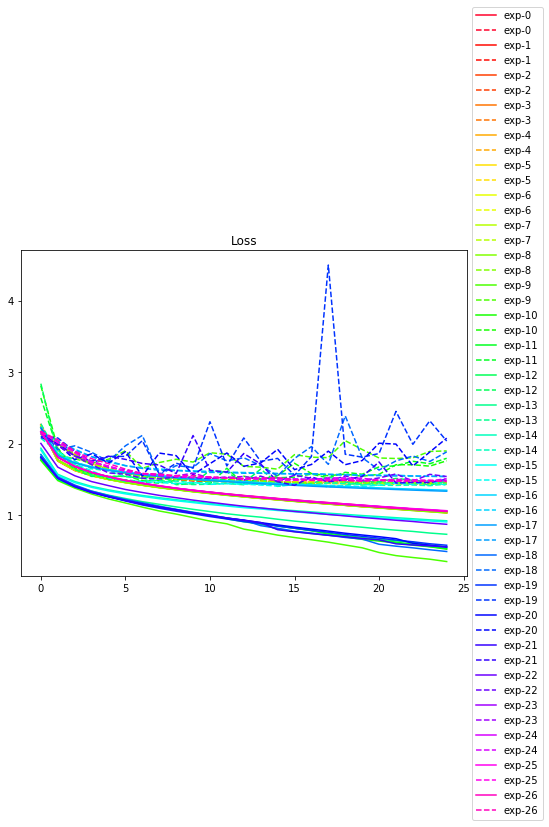

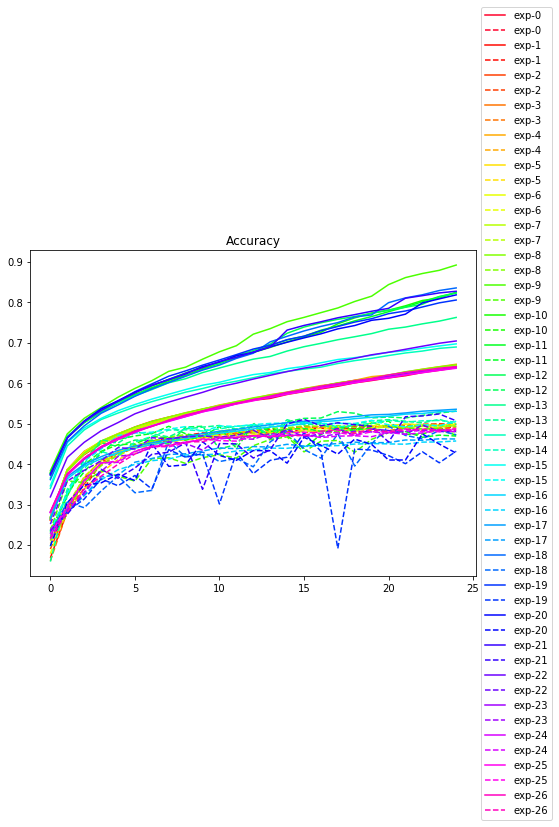

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()